# Training a single neuron using PyTorch

This is an example of how to implement a neuron and its training using PyTorch. I am using  mini-batch gradient descent (aka stochastic gradient descent) and sigmoid as the activation function. I am trahing the neuron to predict the probability of a binary label.

I am using the classic [Anderson's Iris data set](https://en.wikipedia.org/wiki/Iris_flower_data_set) containing samples of three types of flowers and their petal length and width. It is a simple dataset that is often used in introductions to machine learning to demonstrate classification algorithms. Here I am using it to demonstrate how to train a neuron using PyTorch. To use it to train a single neuron I am removing one of the flowers and two of the four features from the dataset since it is generally not feasible to train a single neuron to classify three classes and two features will be enough to demonstrate that the neuron can be trained. 

Contents:

1. Loading the dataset using scikit-learn
2. Exploring the dataset and removing unwanted features and classes
3. Converting the dataset into pytorch tensors and creating dataloaders
4. Implementation of a neuron and its training using mini-batch gradient descent with PyTorch
5. Training and evaluating the neuron using accuracy and confusion matrix and visualising the decision boundary

### 1. Load the Iris dataset using scikit-learn

In [1]:
import matplotlib.pyplot as plt
# I am using the intel optimized version of sklearn if you don't have an Intel CPU, you can remove the following lines:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.datasets import load_iris
# Load the Iris dataset
iris = load_iris()
print("The dataset contains {} samples with {} features and the labels {}.".format(iris.data.shape[0], iris.data.shape[1], iris.target_names))

# Extract the feature data and target labels
X_original = iris.data
y_original = iris.target

The dataset contains 150 samples with 4 features and the labels ['setosa' 'versicolor' 'virginica'].


### 2. Visualize the Dataset with Seaborn

The dataset contains three species of flowers and four features for each sample. The features are the sepal length, sepal width, petal length, and petal width. Lets explore a pairplot that shows the relationship between each pair of two features.

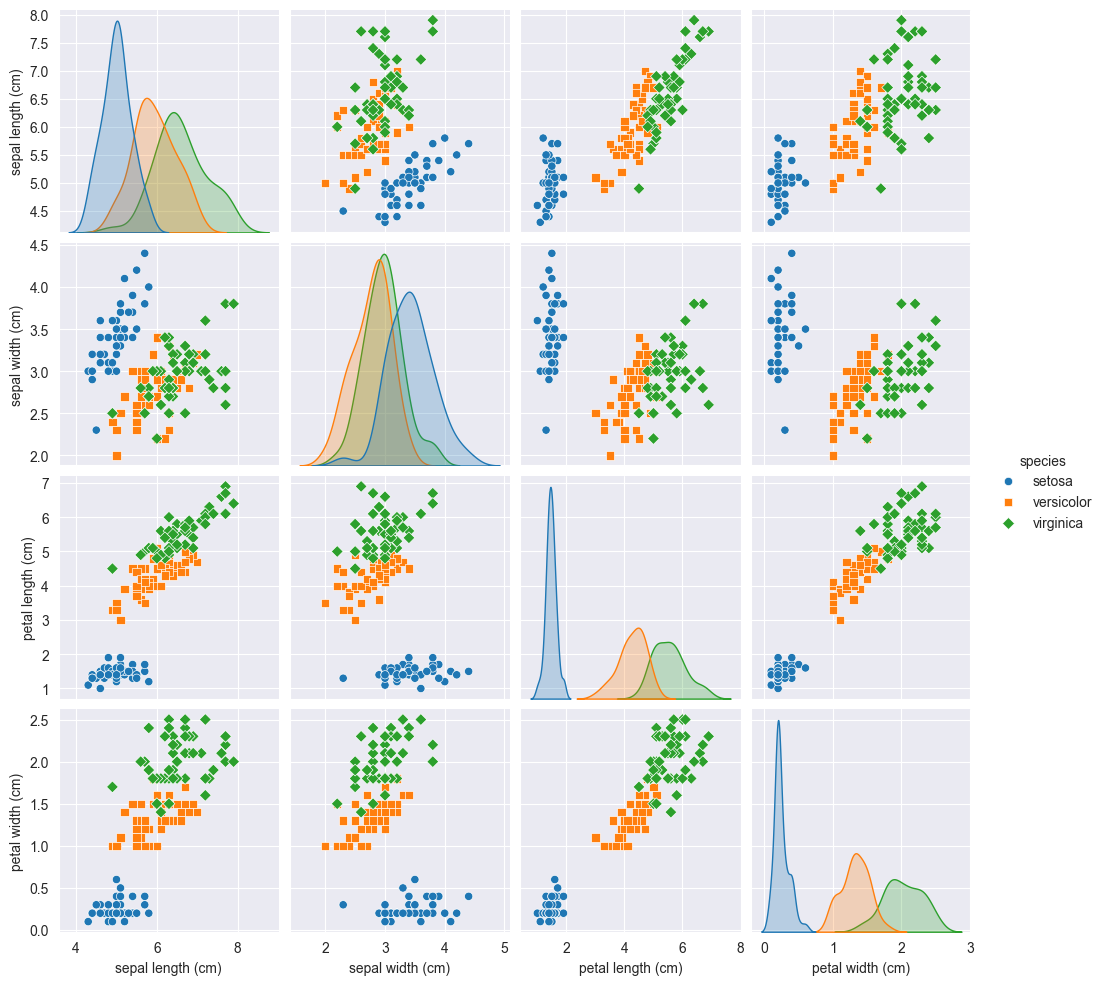

In [3]:
import seaborn as sns
import pandas as pd
# For seaborn it is convenient to use a pandas DataFrame
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names) 
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
sns.pairplot(iris_df, hue='species', markers=["o", "s", "D"])
plt.show()

I decided to remove the Versicolor class from the dataset since it is generally not feasible to train a single neuron to classify three classes. The remaining samples of Setosa and Virginica should allow us to see a nice decision boundary between the two after we've trained the neuron.

In [4]:
import numpy as np
# Get the index that corresponds to 'virginica'
versicolor_idx = np.where(iris.target_names == 'virginica')[0][0]
# Find indices where the target label is not 'virginica'
non_versicolor_idx = y_original != versicolor_idx
# Filter out 'virginica' samples
X = X_original[non_versicolor_idx]
y = y_original[non_versicolor_idx]
# And remember the remaining labels
flower_labels = iris.target_names[:2] 
feature_names = iris.feature_names

# remove two columns from the feature matrix
X = X[:, 2:]  # Keep only petal length and petal width
feature_names = feature_names[2:]  # Keep only petal length and petal width

<Axes: xlabel='petal length (cm)', ylabel='petal width (cm)'>

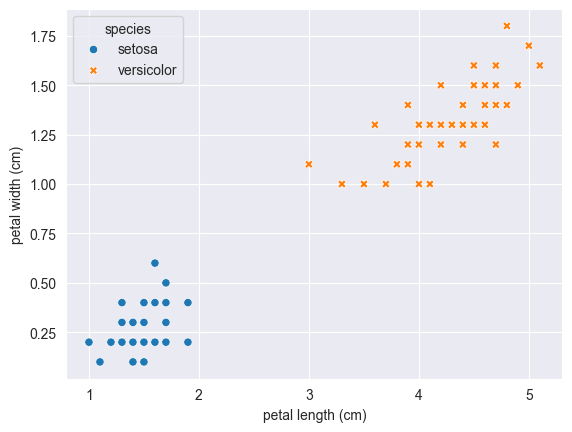

In [5]:
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['species'] = pd.Categorical.from_codes(y, flower_labels)
# sns scatterplot
sns.scatterplot(data=iris_df, x=feature_names[0], y=feature_names[1], hue='species', style='species')

### Convert the dataset to PyTorch tensors and create dataloaders

To train the neuron, we need to convert the data to PyTorch tensors and create datasets and dataloaders. I am using 80% of the data for training and 20% for testing. I am using a batch size of 10. 

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# First, convert the whole dataset to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a PyTorch dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Determine split sizes
total_count = len(dataset)
test_count = int(0.2 * total_count)
train_count = total_count - test_count

# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [train_count, test_count])

# Create PyTorch dataloaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Implementation of the neuron, training and evaluation

In [7]:
class Neuron:
    def __init__(self):
        np.random.seed(42)
        # Four weights and one bias term
        self.weights = torch.randn(3, 1)  # This already uses mean=0 and std=1 by default
        self.loss = []

    def sigmoid(self, x):
        return torch.sigmoid(x)
        
    def train(self, train_loader, learning_rate=0.01, epochs=100):
        for _ in range(epochs):
            for x_batch, y_batch in train_loader:
                # x_batch has the shape (batch_size, 2) 
                # but we need to add a bias term by adding a column of ones 
                x_batch = torch.cat((x_batch, torch.ones((x_batch.shape[0], 1))), 1)                
                
                # For the forward pass we simply multiply the batch of features with the weights vector
                # and then apply the sigmoid activation function to get the predictions                
                y_hat = self.sigmoid(torch.matmul(x_batch, self.weights))                
                # due to the matrix multiplication, y_hat is now a two-dimensional tensor
                # with shape (10, 1) where the 2nd dimension is not used. Let's remove it. 
                y_hat = y_hat.squeeze() # y_hat is now a one-dimensional tensor of length 10
                
                # Calculate the loss by comparing the predictions with the actual labels
                errors = y_hat - y_batch # gives a one-dimensional tensor of length 10
                
                # Calculate the gradient of the loss with respect to the weights
                loss_gradient = torch.matmul(errors, x_batch) / x_batch.size(0) # 1-d tensor of length 3     
                
                # Update weights
                weight_update = learning_rate * loss_gradient
                self.weights -= weight_update.view(-1, 1) # weight_update is a 1-d tensor of length 5
                self.loss.append(torch.mean(errors ** 2).item())
                
    def eval(self, test_loader):
        total_predictions = correct_predictions = 0
        confusion_matrix = torch.zeros(2, 2)  # Assuming binary classification

        for x_batch, y_batch in test_loader:
            y_hat = self.predict(x_batch)
            y_hat = torch.round(y_hat)  # Round to get class predictions
            total_predictions += test_loader.batch_size

            for i in range(len(y_batch)):
                if y_batch[i] == y_hat[i]: correct_predictions += 1
                confusion_matrix[y_batch[i], y_hat[i]] += 1

        accuracy = correct_predictions / total_predictions
        return accuracy, confusion_matrix
        
    # Return the probability—not the corresponding 0 or 1 label.
    def predict(self, features):
        features = torch.cat((features, torch.ones((features.shape[0], 1), dtype=torch.float32)), 1)
        prediction = self.sigmoid(features @ self.weights)
        prediction = prediction.squeeze()
        prediction = torch.round(prediction)
        prediction = prediction.type(torch.long)
        return prediction


### Train the neuron on the data and visualise the training loss

Text(0, 0.5, 'MSE Loss')

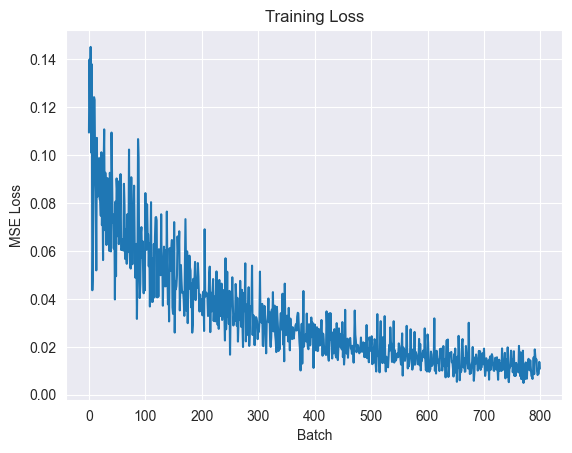

In [8]:
# Train the neuron
neuron = Neuron()
neuron.train(train_loader, learning_rate=0.05, epochs=100)
# Plot the loss
plt.plot(neuron.loss)
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('MSE Loss')

### Now evaluate the neuron on the test data

Accuracy: 100.00%


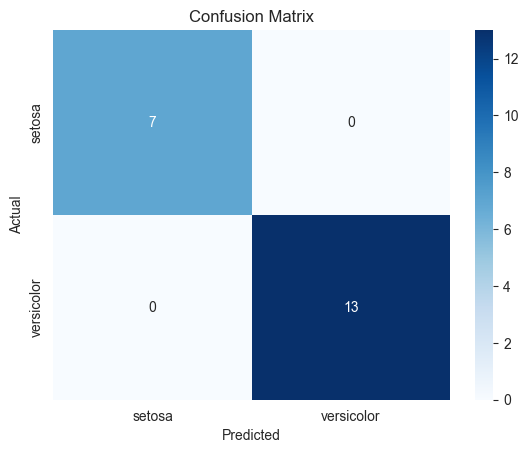

In [9]:
acc, confusion_matrix = neuron.eval(test_loader)
print(f'Accuracy: {acc * 100:.2f}%')

# visualise the confusion matrix
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=flower_labels, yticklabels=flower_labels)  
# add title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

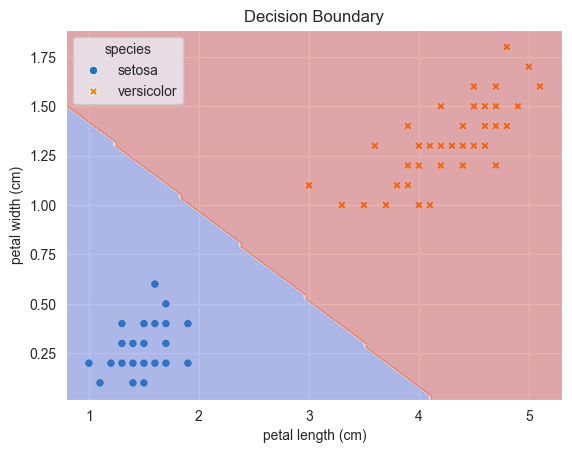

In [10]:
# And visualise the decision boundary
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['species'] = pd.Categorical.from_codes(y, flower_labels)
# sns scatterplot
sns.scatterplot(data=iris_df, x=feature_names[0], y=feature_names[1], hue='species', style='species')

# now add the decision boundary of the neuron based on the predictoins of the neuron
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# Create a meshgrid using torch.meshgrid
x_range = torch.linspace(x_min, x_max, 100)
y_range = torch.linspace(y_min, y_max, 100)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')

Z = neuron.predict(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision Boundary')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()

As we can see, the neuron has learned to separate the two classes quite well. The decision boundary is a straight line (it appears jittery because we are using a grid of samples to approximate it), which is expected since we are using a single neuron. The accuracy of the neuron is 100% on the test data. This is expected since the dataset is simple and the neuron has enough capacity to learn the decision boundary.